## Benchmarking zero-shot TimesFM on Finance GMV forecast

### Summary of findings

[TimesFM](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/) is a newly released Transformer-based time series forecasting model from Google, similar to [Moirai](https://blog.salesforceairesearch.com/moirai/). It is pre-trained on a large dataset of time series from various domains and can be used for zero-shot forecasting, or forecasting on data that the model wasn’t explicitly trained on. In this notebook, we evaluate TimesFM's zero-shot capabilities on our GMV forecasting use case similar to the [benchmark](https://github.com/Shopify/finance-data/blob/main/GMV%20Forecast/Moirai%20Benchmark/moirai_benchmark.ipynb) we did on Moirai in April.

In benchmarking, we see that TimesFM performs significantly better than Moirai (15% vs 21% SMAPE). However, the current GMV forecasting model, based on Prophet, still outperforms TimesFM (8% vs 15% SMAPE). This is attributed to hyperparameter tuning and robust support for seasonality, holidays, and external regressors. The current model uses economic regressors such as US goods consumption and e-commerce adoption, and regional holidays such as Mother’s Day, BFCM, and Christmas. Similar to Moirai, TimesFM is new and currently lacks such support and is therefore not yet a suitable replacement for Prophet for our GMV forecasting use case.

Given its relatively strong zero-shot performance on this use case compared to Moirai, TimesFM could potentially be used for use cases where we need to quickly create forecasts without investing significant expertise, time, and/or compute. The TimesFM [paper](https://arxiv.org/pdf/2310.10688) states they have done fine-tuning, however, we have not seen this capability in the [codebase](https://github.com/google-research/timesfm).

Similar to Moirai, the next steps for further exploration of TimesFM would be:

- Pass these findings to other Data teams that may have more immediately applicable use cases (Shop, Infrastructure, etc.)
- Once TimesFM has added support for fine-tuning, external regressors and holidays, evaluate the performance of a fine-tuned model on GMV

### Detailed analysis

#### Time series forecast comparison

Figure 1: TimesFM zero-shot and Prophet GMV forecasts (US Region)

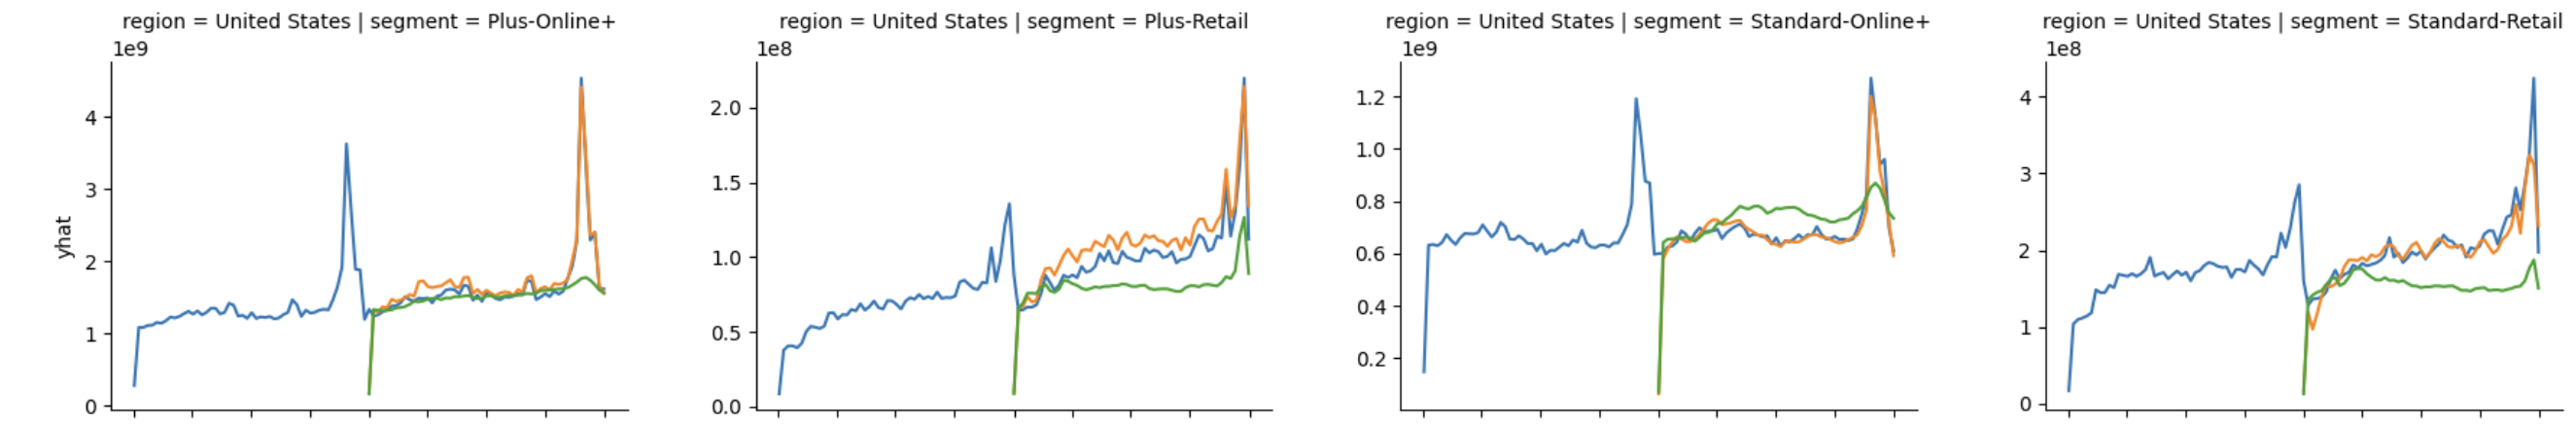

TimesFM currently lacks support for external regressors and holidays. As a result, TimesFM zero-shot isn't able to capture seasonality or holidays well. And this is causing it to do poorly on predicting BFCM.

#### Comparison of performance metrics for each model

| Model            | Weighted Smape | RMSE         |
| :--------------- | :------------- | :----------- |
| Holt Winters     | 0.193734       | 8.377287e+06 |
| Mean             | 0.215601       | 1.346153e+07 |
| Median           | 0.244165       | 1.398685e+07 |
| Moirai zero-shot | 0.213812       | 1.365299e+07 |
| TimesFM zero-shot |	0.151672	| 1.118944e+07 |
| Prophet          | 0.081087       | 2.586726e+06 |

Our latest Prophet-based GMV forecasting model significantly outperforms TimesFM zero-shot in both metrics. This can be attributed to several factors:
1. Prophet supports external regressors (e.g. consumption, ecommerce adoption) and non-cyclical holidays (e.g. BFCM), which TimesFM currently lacks.
2. We have tuned Prophet's hyperparameters for each segment to minimize SMAPE. TimesFM zero-shot has not been tuned.

### Instructions to run this notebook

1. 

### Imports, constants, and helper functions

In [1]:
# Imports
# %pip -q install seaborn
# %pip -q install pyarrow
# %pip -q install huggingface_hub
import pandas as pd
import numpy as np
import seaborn as sns

import timesfm
from huggingface_hub import login
login()

2024-05-16 19:01:43.863095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
# Constants
GMV_FORECAST_TRAINING_DATA_PATH = "training.parquet"
PROPHET_BENCHMARK_PATH = "prophet_benchmark.parquet"
GROUPS = ["forecast_region_group","merchant_type","sales_channel","currency"]
TRAINING_CUTOFF_DATE = "2023-01-01"
BENCHMARK_END_DATE = "2024-01-01"

In [3]:
# Helper functions
def smape(group):
    return 2 * np.mean(np.abs(group["y"] - group["yhat"]) / (np.abs(group["y"]) + np.abs(group["yhat"])))


def compute_grouped_weighted_smape(df, groups):
    return np.sum(df.groupby(groups).apply(smape) * df.groupby(groups)["y"].sum()) / df["y"].sum()


def rmse(group):
    return np.sqrt(np.mean(np.power(group["y"] - group["yhat"], 2)))


def sample_to_df(forecast, quantile):
    samples = forecast.quantile(quantile)
    h = len(samples)
    dates = pd.date_range(forecast.start_date.to_timestamp(), freq=forecast.freq, periods=h)
    df = pd.DataFrame({'ds': dates, 'yhat': samples.T})
    df["segment"] = forecast.item_id
    return df

def forecast_drift_by_segment(cv_preds, df_train, groups, hue, actuals_min_date, actuals_max_date):
    tmp = (
        df_train[(df_train["ds"] >= actuals_min_date)&(df_train["ds"] <= actuals_max_date)]
        .groupby(["ds"]+groups)["y"]
        .first()
        .reset_index()
        .rename(columns={"y": "yhat"})
    )
    tmp[hue] = "Actuals"
    res = pd.concat([cv_preds, tmp]).reset_index(drop=True)
    
    res.rename(columns={"forecast_region_group":"region"}, inplace=True)
    res["segment"] = res["merchant_type"] + "-" + res["sales_channel"]
    by = [pd.Grouper(key="ds", freq="w"), hue, "region", "segment"]

    # Get a list of regions sorted by GMV USD descending, regions with higher GMV are generally easier to forecast
    region_gmv_order = list(df_train.groupby("forecast_region_group")["gmv_usd"].sum().sort_values(ascending=False).index)
    
    fcg = sns.FacetGrid(
        res.groupby(by)["yhat"].sum().reset_index(),
        row="region",
        col="segment",
        hue=hue,
        sharey=False,
        aspect=1.5,
        row_order=region_gmv_order
    )
    fcg.map(sns.lineplot, "ds", "yhat")
    fcg.add_legend()
    return fcg

def calculate_metrics_by_model(df, groups):
    metrics = pd.concat([
        df.groupby("model").apply(lambda x: compute_grouped_weighted_smape(x, groups)),
        df.groupby("model").apply(rmse)
    ], axis=1)
    metrics.columns = ["weighted smape", "rmse"]
    return metrics

### Load and prepare training data

In [14]:
df_train = pd.read_parquet(GMV_FORECAST_TRAINING_DATA_PATH)

# Create a single segment column from other columns since TimesFM expects it
df_train["segment"] = df_train.forecast_region_group + "_" + df_train.merchant_type + "_" + df_train.sales_channel + "_" + df_train.currency

### Forecast GMV with TimesFM zero-shot

In [5]:
tfm = timesfm.TimesFm(
    context_len=512, # Max context length supported
    horizon_len=365,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 2.62 seconds.
Restoring checkpoint from /home/codespace/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/6e882b9d59c38c0e06a8d5c5632acffa446b7274/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.22 seconds.
Jitting decoding.
Jitted decoding in 29.16 seconds.


In [27]:
df_test = df_train[df_train.ds<TRAINING_CUTOFF_DATE]

In [28]:
df_test['unique_id'] = df_test['segment']

/tmp/ipykernel_2753/309185100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['unique_id'] = df_test['segment']


In [29]:
forecast_df = tfm.forecast_on_df(
    inputs=df_test,
    freq="D",  # daily
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.


2024-05-16 19:20:32.060519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-16 19:20:32.072054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-16 19:20:32.072054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-16 19:20:32.095908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-16 19:20:32.095963: W tensorflow/stream_executor/platform/default/dso_lo

Finished preprocessing dataframe.
Finished forecasting.


In [30]:
forecast_df.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,Australia_Plus_Online+_AUD,2023-01-01,23264710.0,20381240.0,21440040.0,22034524.0,22814572.0,23264710.0,23960604.0,24612212.0,25409880.0,27011232.0
1,Australia_Plus_Online+_AUD,2023-01-02,23963050.0,20829636.0,21927486.0,22675552.0,23417154.0,23963050.0,24650666.0,25349388.0,26377518.0,28071546.0
2,Australia_Plus_Online+_AUD,2023-01-03,23991390.0,20882744.0,21983374.0,22769472.0,23297734.0,23991390.0,24674294.0,25310108.0,26371230.0,28089540.0
3,Australia_Plus_Online+_AUD,2023-01-04,24165104.0,21014684.0,22118396.0,22972164.0,23501432.0,24165104.0,24785448.0,25621364.0,26582924.0,28431658.0
4,Australia_Plus_Online+_AUD,2023-01-05,24005266.0,20953098.0,21980610.0,22770360.0,23489156.0,24005266.0,24656910.0,25304836.0,26384456.0,28144868.0


### Visually comparing TimesFM and Prophet forecasts

In [33]:
# Load prophet benchmark
prophet_benchmark = pd.read_parquet(PROPHET_BENCHMARK_PATH)

In [41]:
timesfm_forecast = forecast_df.copy()

In [ ]:
timesfm_forecast['segment'] = timesfm_forecast['unique_id']
timesfm_forecast['yhat'] = timesfm_forecast['timesfm']

In [42]:
# Split segment column back into forecast_region_group, merchant_type, sales_channel, and currency
timesfm_forecast[GROUPS] = timesfm_forecast["segment"].str.split("_", expand=True)

# Bring in GMV actuals from training data
timesfm_forecast = timesfm_forecast.merge(df_train.reset_index()[["ds","segment","y"]], on=["ds", "segment"], how="left")

timesfm_forecast["model"] = "TimesFM zero-shot"

# Only keep columns required for evaluation
timesfm_forecast = timesfm_forecast[["model", "ds", *GROUPS, "y", "yhat"]]

In [43]:
# Combine TimesFM and Prophet forecasts into a single dataframe for analysis
all_forecasts = pd.concat([timesfm_forecast, prophet_benchmark])

all_forecasts = all_forecasts[(all_forecasts.ds >= TRAINING_CUTOFF_DATE) & (all_forecasts.ds < BENCHMARK_END_DATE)]

/tmp/ipykernel_2753/3035441329.py:35: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  by = [pd.Grouper(key="ds", freq="w"), hue, "region", "segment"]


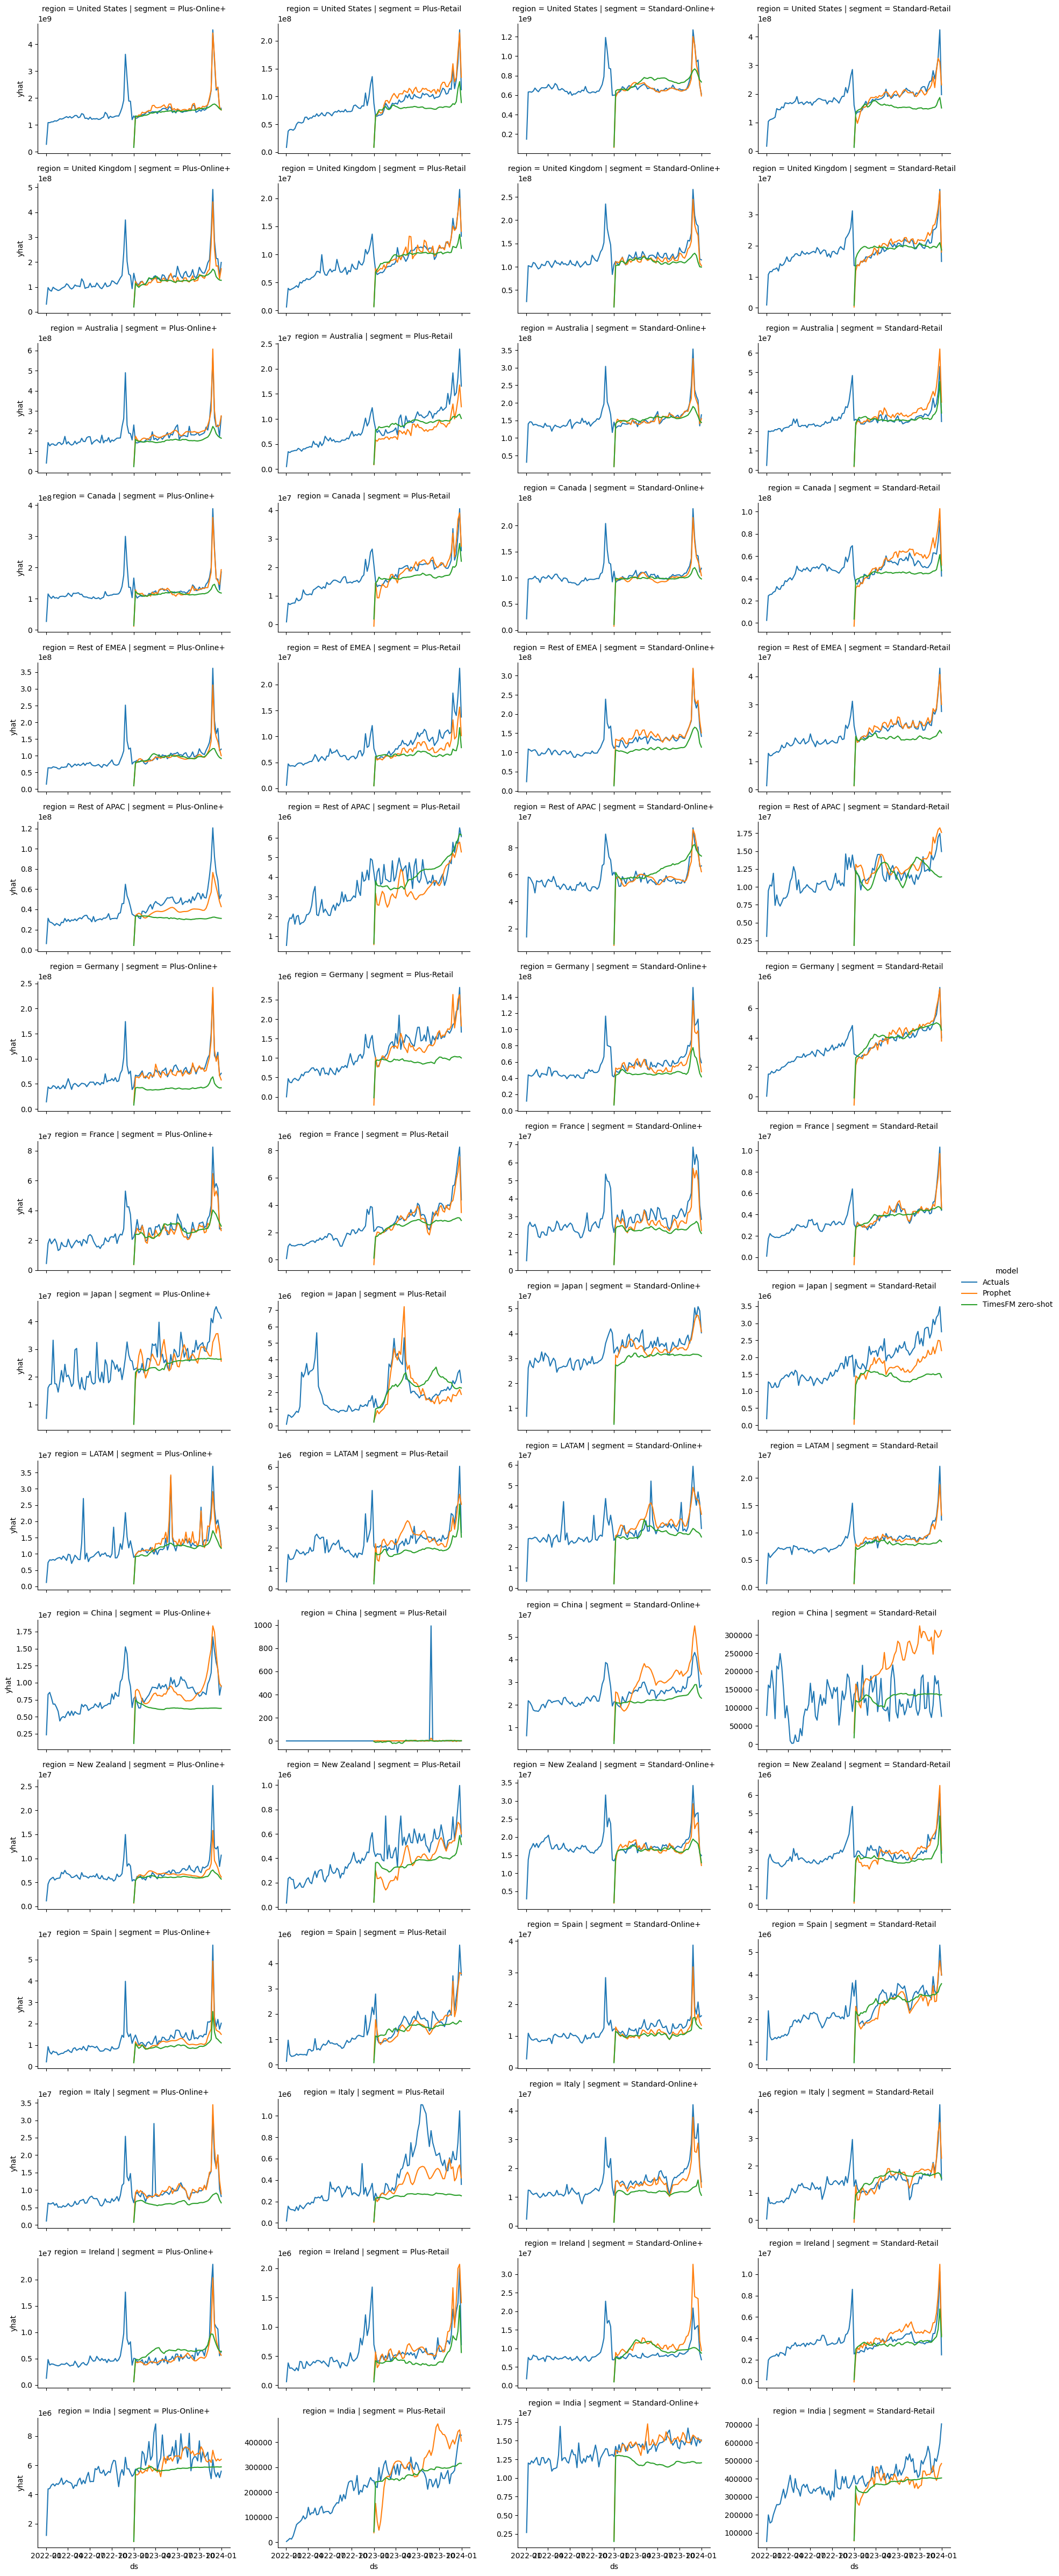

In [44]:
# Only plot TimesFM and Prophet
models_to_plot = ["TimesFM zero-shot", "Prophet"]
forecasts_to_plot = all_forecasts[all_forecasts.model.isin(models_to_plot)]

forecast_drift_by_segment(
    cv_preds=forecasts_to_plot, 
    df_train=df_train.reset_index(), 
    groups=GROUPS, 
    hue="model", 
    actuals_min_date='2022-01-01', 
    actuals_max_date="2023-12-31"
)

### Calculate performance metrics for all models

In [45]:
calculate_metrics_by_model(all_forecasts, GROUPS)

/tmp/ipykernel_2753/3035441329.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return np.sum(df.groupby(groups).apply(smape) * df.groupby(groups)["y"].sum()) / df["y"].sum()
/tmp/ipykernel_2753/3035441329.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return np.sum(df.groupby(groups).apply(smape) * df.groupby(groups)["y"].sum()) / df["y"].sum()
/tmp/ipykernel_2753/3035441329.py:7: DeprecationWarnin

,weighted smape,rmse
model,,
Holt Winters,0.193734,8.377287e+06
Mean,0.215601,1.346153e+07
Median,0.244165,1.398685e+07
Prophet,0.081087,2.586726e+06
TimesFM zero-shot,0.151672,1.118944e+07
